In [1]:
import torch
from google.colab import files
from IPython.display import Image
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd '/gdrive/My Drive/Colab Notebooks/sperm-analysis'

/gdrive/My Drive/Colab Notebooks/sperm-analysis


In [3]:
import os
import json
import math
import numpy as np
import pandas as pd
import random
from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn 

import cv2
from PIL import Image
from tqdm.auto import tqdm, trange
import glob
import re
from pynvml import *
from datetime import datetime

import torchvision,torch
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
from torchvision import models
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from torchsummary import summary

In [4]:
Dataframe = pd.read_csv('Merged_data.csv')
Dataframe = Dataframe.drop(['Unnamed: 0'],axis=1)

In [5]:
def getFrames(filename):
  v_cap = cv2.VideoCapture(filename)
  v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(v_len)  
  fps = 30
  allFrames = []
  i = 1
  count=1
  for fn in range(v_len):
    success, frame = v_cap.read()
    if (success is False):
      continue
    allFrames.append(frame)
    i+=1
  print(i)
  v_cap.release()
  return allFrames,fps
    
def makeVideo(sourceFolder, destFolder):
  testarray,fps = getFrames(sourceFolder)
  testarray = np.array(testarray)
  frame0 = testarray[0]
  frames,height,width,channels = testarray.shape
  print(frames,fps,height,width,channels)
  fps = fps
  cropSize = (640, 640)
  fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
  out = cv2.VideoWriter(destFolder, fourcc, fps, cropSize)
  
  for i in range(frames):
    outputA = testarray[i,:,:,0]
    output = cv2.resize(outputA, cropSize, interpolation = cv2.INTER_CUBIC)

    finaloutput = cv2.merge([output,output,output])
    out.write(finaloutput)

  out.release()

In [10]:
ls sperm_bits/

cropped_video/  frames/  sperm_videos@  with_cover_slip_and_hemocytometer@


In [11]:
ls sperm_bits/'with_cover_slip_and_hemocytometer'/

Data215.avi  Data217.avi  Data219.avi  Data221.avi  Data223.avi  Data226.avi
Data216.avi  Data218.avi  Data220.avi  Data222.avi  Data224.avi


In [15]:
ls sperm_bits

ls: cannot access 'files_path': No such file or directory


In [14]:
files_path = 'sperm_bits/with_cover_slip_and_hemocytometer/'
files = os.listdir(files_path)
for filename in files:
  makeVideo(files_path + filename,"sperm_bits/cropped_video/"+ filename)

148
149
148 30 1200 1920 3
148
149
148 30 1200 1920 3
149
150
149 30 1200 1920 3
149
150
149 30 1200 1920 3
151
152
151 30 1200 1920 3
154
155
154 30 1200 1920 3
148
149
148 30 1200 1920 3
152
153
152 30 1200 1920 3
168
169
168 30 1200 1920 3
149
150
149 30 1200 1920 3
156
157
156 30 1200 1920 3


In [17]:
filename = 'sperm_bits/with_cover_slip_and_hemocytometer/Data215.avi'
v_cap = cv2.VideoCapture(filename)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = v_cap.get(cv2.CAP_PROP_FPS)

In [18]:
v_len, fps

(148, 26.0)

## Frame selection

In [19]:
def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename) #open the video file
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  #passing the respective property name into the .get method of the video pointer will allow us to obtain the total number of frames in the video 
    frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)
    all_frames = []
    count = 0
    for fn in range(v_len):
        if (count==n_frames):
          break
        success, frame = v_cap.read() #reades every frame if the frames are over it will go to the next video
        if success is False:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
        frames.append(frame)
        count+=1
    v_cap.release()
    return frames

def store_frames(frames, id, path2store):
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path_2_folder = os.path.join(path2store,id)
        os.makedirs(path_2_folder, exist_ok = True)
        path2img = os.path.join(path2store, id , id + "_frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame) 

In [20]:
video_names = os.listdir("sperm_bits/cropped_video/")
print(video_names)

['Data214.avi', 'Data210.avi', 'Data211.avi', 'Data213.avi', 'Data212.avi', 'Data209.avi', 'Data215.avi', 'Data216.avi', 'Data217.avi', 'Data218.avi', 'Data219.avi', 'Data220.avi', 'Data221.avi', 'Data222.avi', 'Data223.avi', 'Data224.avi', 'Data226.avi']


In [21]:
path2load = "sperm_bits/cropped_video/"
path2store = "sperm_bits/frames/"
for video in tqdm(video_names):
  frames = get_frames(path2load + video , n_frames= 100)
  store_frames(frames, video[:-4], path2store)

  0%|          | 0/17 [00:00<?, ?it/s]

In [22]:
ls sperm_bits/frames/

Data209/  Data212/  Data215/  Data218/  Data221/  Data224/
Data210/  Data213/  Data216/  Data219/  Data222/  Data226/
Data211/  Data214/  Data217/  Data220/  Data223/


In [35]:
from PIL import Image as im
frames = get_frames("sperm_bits/cropped_video/Data226.avi" , n_frames= 100)
data = im.fromarray(frames[0])

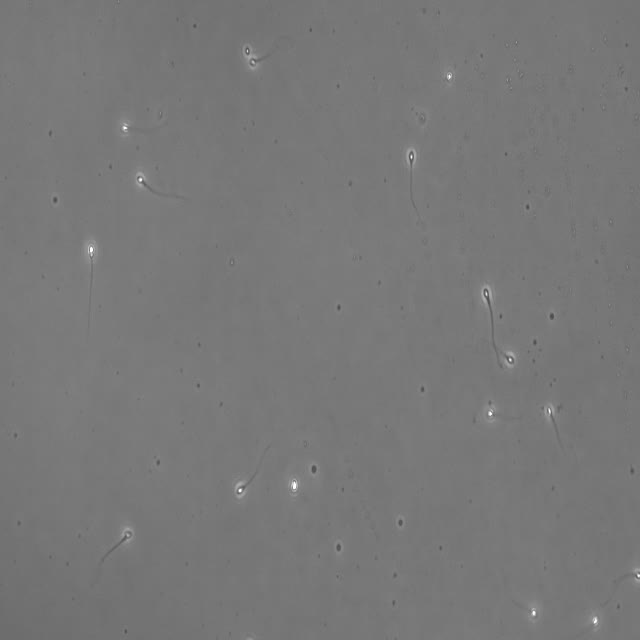

In [36]:
data

In [ ]:
ls sperm_bits/

cropped_video/  frames/  sperm_videos@


In [ ]:
for files in k:
  print(len(os.listdir('sperm_bits/frames/' + files)))

100
100
100
100
100
52


In [ ]:
k

['Data209', 'Data214', 'Data210', 'Data211', 'Data213', 'Data212']